In [1]:
%reload_kedro

2023-05-09 14:22:25,201 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/gpalazzo/Desktop/dev/crypto_msc_thesis
2023-05-09 14:22:26,005 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-05-09 14:22:26,205 - kedro.extras.extensions.ipython - INFO - ** Kedro project crypto_thesis
2023-05-09 14:22:26,205 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from crypto_thesis.data_domains.spine import spine_build_target_labels

### Label balancing

In [6]:
df_spine_preproc = catalog.load("spine_preprocessing")
df_spine_logret = catalog.load("spine_log_ret")
df_mt = catalog.load("master_table_multic")

spine_params = catalog.load("params:spine_labeling")
mt_cls_bds_params = catalog.load("params:mt_class_bounds")

2023-05-09 14:22:44,372 - kedro.io.data_catalog - INFO - Loading data from `spine_preprocessing` (ParquetDataSet)...
2023-05-09 14:22:44,387 - kedro.io.data_catalog - INFO - Loading data from `spine_log_ret` (ParquetDataSet)...
2023-05-09 14:22:44,406 - kedro.io.data_catalog - INFO - Loading data from `master_table_multic` (ParquetDataSet)...
2023-05-09 14:22:44,418 - kedro.io.data_catalog - INFO - Loading data from `params:spine_labeling` (MemoryDataSet)...
2023-05-09 14:22:44,419 - kedro.io.data_catalog - INFO - Loading data from `params:mt_class_bounds` (MemoryDataSet)...


In [7]:
# test a different tau value to evaluate class balancing
spine_params

{'tau': 0.35}

In [8]:
df_spine_lbl = spine_build_target_labels(df=df_spine_preproc, 
                                         df_log_ret=df_spine_logret, 
                                         label_params=spine_params)

In [9]:
df_spine_lbl.label.value_counts() / df_spine_lbl.shape[0]

bottom    0.630487
top       0.369513
Name: label, dtype: float64

In [10]:
# check master table balance, it must be 50/50%
df_mt.label.value_counts() / df_mt.shape[0]

top       0.500292
bottom    0.499708
Name: label, dtype: float64

### Volume bar time interval plots

In [11]:
df_spine = catalog.load("spine_labeled")
df_ftes = catalog.load("fte_binance").dropna()

2023-05-09 14:23:42,027 - kedro.io.data_catalog - INFO - Loading data from `spine_labeled` (ParquetDataSet)...
2023-05-09 14:23:42,068 - kedro.io.data_catalog - INFO - Loading data from `fte_binance` (ParquetDataSet)...


In [12]:
df_spine_aux = df_spine.copy()

df_spine_aux = df_spine_aux.merge(df_ftes[["open_time", "close_time"]], \
                                  on=["open_time", "close_time"] , \
                                 how="inner")

df_spine_aux.loc[:, "open_close_duration_sec"] = (df_spine_aux["close_time"] - df_spine_aux["open_time"]).dt.total_seconds()
df_spine_aux.loc[:, "close_target_duration_sec"] = (df_spine_aux["target_time"] - df_spine_aux["close_time"]).dt.total_seconds()

df_spine_aux.loc[:, "open_close_duration_min"] = df_spine_aux["open_close_duration_sec"] / 60.0
df_spine_aux.loc[:, "close_target_duration_min"] = df_spine_aux["close_target_duration_sec"] / 60.0

In [13]:
df_spine_aux.head()

,open_time,close_time,target_time,logret_cumsum,target_time_close,target_time_log_return,close_time_close,std,close_to_tgt_time_logret,pctchg_cumsum,close_to_tgt_time_pctchg,label,open_close_duration_sec,close_target_duration_sec,open_close_duration_min,close_target_duration_min
0,2019-11-29 06:00:00,2019-11-29 21:45:00,2019-12-01 00:15:00,0.030120,7489.00,-0.002034,7689.96,0.003592,-0.026480,0.030578,-0.026133,bottom,56700.0,95400.0,945.0,1590.0
1,2019-11-29 22:00:00,2019-12-01 00:15:00,2019-12-01 17:45:00,-0.026480,7323.22,0.002091,7489.00,0.002569,-0.022385,-0.026133,-0.022136,bottom,94500.0,63000.0,1575.0,1050.0
2,2019-12-01 00:30:00,2019-12-01 17:45:00,2019-12-02 17:30:00,-0.022385,7295.00,0.003579,7323.22,0.003163,-0.003861,-0.022136,-0.003853,bottom,62100.0,85500.0,1035.0,1425.0
3,2019-12-01 18:00:00,2019-12-02 17:30:00,2019-12-04 01:45:00,-0.003861,7156.69,-0.001915,7295.00,0.003072,-0.019142,-0.003853,-0.018960,bottom,84600.0,116100.0,1410.0,1935.0
4,2019-12-04 02:00:00,2019-12-04 15:30:00,2019-12-05 09:45:00,0.041308,7308.18,-0.002288,7458.51,0.007273,-0.020361,0.042173,-0.020156,bottom,48600.0,65700.0,810.0,1095.0


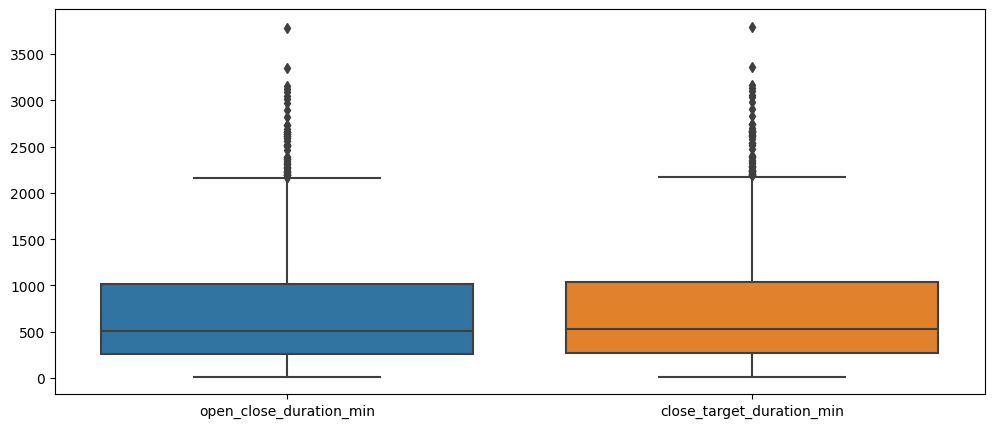

In [14]:
df_plot = df_spine_aux[["close_time", "open_close_duration_min", "close_target_duration_min"]] \
                        .set_index("close_time") \
                        .sort_index()

plt.figure(figsize=(12, 5))
plot = sns.boxplot(data=df_plot)

fig = plot.get_figure()
fig.savefig("/Users/gpalazzo/Desktop/fig_boxplot_time_windows.png")

In [15]:
df_plot.describe()

,open_close_duration_min,close_target_duration_min
count,2310.000000,2310.000000
mean,705.642857,719.928571
std,578.841704,579.030908
min,15.000000,15.000000
25%,255.000000,270.000000
50%,510.000000,525.000000
75%,1020.000000,1035.000000
max,3780.000000,3795.000000
